In [26]:
import datetime as dt
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.integrate import solve_ivp
from scipy.optimize import minimize   
from sklearn.metrics import r2_score

import plotting

In [27]:
# configure plotting
plotting.configure(grid=False)
hex_blue = plotting.default_colors('blue')
hex_red = plotting.default_colors('red')
hex_purple = plotting.default_colors('purple')

In [28]:
# load data
DATA_DIR = 'data'
FILE_NAMES = ['1st_wave_data_cro.csv',
              '2nd_wave_data_cro.csv']
FILE_PATHS = [os.path.join(os.pardir, DATA_DIR, FILE_NAMES[0]),
              os.path.join(os.pardir, DATA_DIR, FILE_NAMES[1])]
df_1 = pd.read_csv(FILE_PATHS[0])
df_2 = pd.read_csv(FILE_PATHS[1])
df = pd.concat([df_1, df_2[1:-1]], sort=False)

positives = np.cumsum(df.confirmed_positives.values)
recovered = df.estimate_recovered.values
deceased = np.cumsum(df.confirmed_deceased.values)
removed = recovered + deceased
active = positives - removed

In [29]:
# start of different epi waves
eff_dates=[dt.datetime(2020, 2, 25), dt.datetime(2020, 6, 10), dt.datetime(2020, 8, 10)]

diff_1 = (eff_dates[1] - eff_dates[0]).days
diff_2 = (eff_dates[2] - eff_dates[1]).days

active_1 = active[:diff_1]
active_2 = active[diff_1:diff_1+diff_2]
active_3 = active[diff_1+diff_2:]

recovered_1 = recovered[:diff_1]
recovered_2 = recovered[diff_1:diff_1+diff_2]
recovered_3 = recovered[diff_1+diff_2:]

deceased_1 = deceased[:diff_1]
deceased_2 = deceased[diff_1:diff_1+diff_2]
deceased_3 = deceased[diff_1+diff_2:]

removed_1 = removed[:diff_1]
removed_2 = removed[diff_1:diff_1+diff_2]
removed_3 = removed[diff_1+diff_2:]

In [30]:
# utils

def moving_average(x, w):
    return np.convolve(x, np.ones(w), 'valid') / w

def MSE(y_true, y_pred):
    return np.mean((y_true - y_pred)**2)

In [31]:
# epi models

def SEIR(t, y, beta, alpha, gamma):
    S, E, I, R = y
    N = S + E + I + R
    return [
        -beta*S*I/N, 
        beta*S*I/N - alpha*E, 
        alpha*E - gamma*I,  ##
        gamma*I,
    ]


def SEIR_extended(t, y, beta, delta, alpha, gamma):
    S, E, I, R = y
    N = S + E + I + R
    return [
        -beta*S*I/N - delta*E, 
        beta*S*I/N - alpha*E + delta*E,
        alpha*E - gamma*I,
        gamma*I,
    ]


def SEIRD(t, y, beta, alpha, gamma, mu):
    S, E, I, R, D = y
    N = S + E + I + R
    return [
        -beta*S*I/N, 
        beta*S*I/N - alpha*E, 
        alpha*E - gamma*I -mu*I,
        gamma*I,
        mu*I,
    ]


def SEIRD_extended(t, y, beta, delta, alpha, gamma, mu):
    S, E, I, R, D = y
    N = S + E + I + R + D
    return [
        -beta*S*I/N - delta*E, 
        beta*S*I/N - alpha*E + delta*E, 
        alpha*E - gamma*I - mu*I,
        gamma*I,
        mu*I,
    ]

In [32]:
# loss function

def loss(params, active, removed, IC):
    size = active.size
    sol = solve_ivp(
        fun=SEIR, 
        t_span=(0, size), 
        y0=IC, 
        args=params,
        method='RK45', 
        t_eval=np.arange(0, size, 1), 
        vectorized=True,
    )
    return MSE(sol.y[2], active)

# First wave simple SEIR + MCMC

In [33]:
t = np.arange(active_1.size)
n_future = 45
t_opt = t[:-n_future]
t_ext = t[-n_future:]

In [62]:
guess = [0.1, 0.1, 0.1]
S0 = 4_000  # crude approx.
E0 = 10*active_1[0]
I0 = active_1[0]
R0 = removed_1[0]
IC = [S0, E0, I0, R0]

[fit] S = 38.869429045463384 
[fit] r2 = 0.9943830803834458 
[ext] S = 26.514786791834332 
[ext] r2 = 0.9866493006130735


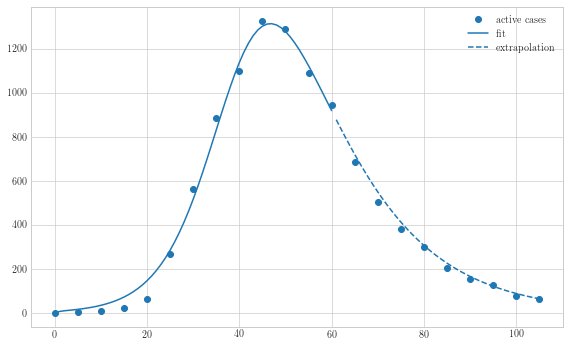

In [63]:
opt = minimize(
    fun=loss, 
    x0=guess,
    args=(active_1[:-n_future], removed_1[:-n_future], IC),
    method='L-BFGS-B',
    bounds=[(1e-5, 1.0)] * len(guess),
    options={'maxiter': 1000, 'disp': True},
)

sol = solve_ivp(
    fun=SEIR, 
    t_span=(0, t_opt.size), 
    y0=IC, 
    args=opt.x,
    method='RK45', 
    t_eval=t_opt, 
    vectorized=True,
)

predict = solve_ivp(
    fun=SEIR, 
    t_span=(0, t.size),
    y0=IC,
    args=opt.x,
    method='RK45',
    t_eval=t, 
    vectorized=True,
    )

# goodness-of-fit
sre_fit = np.sqrt(np.mean((active_1[:-n_future] - sol.y[2])**2))
r2_fit = r2_score(active_1[:-n_future], sol.y[2])
sre_ext = np.sqrt(np.mean((active_1[-n_future:] - predict.y[2][-n_future:])**2))
r2_ext = r2_score(active_1[-n_future:], predict.y[2][-n_future:])
print(
    f'[fit] S = {sre_fit}',
    f'\n[fit] r2 = {r2_fit}',
    f'\n[ext] S = {sre_ext}',
    f'\n[ext] r2 = {r2_ext}'
)

plt.plot(t, active_1, 'o', color=hex_blue, markevery=5, label='active cases')
plt.plot(t_opt, sol.y[2], '-', color=hex_blue, label='fit')
plt.plot(t_ext, predict.y[2][-n_future:], '--', color=hex_blue, label='extrapolation')
plt.legend()
plt.grid()
plt.show()

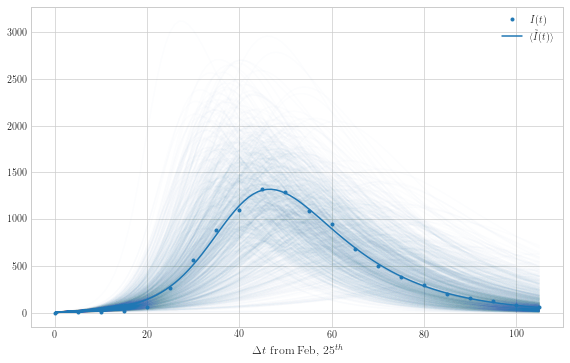

In [69]:
guess = [0.1, 0.1, 0.1]
S0 = 4_000
E0 = 10*active_1[0]
I0 = active_1[0]
R0 = removed_1[0]
IC = [S0, E0, I0, R0]

opt = minimize(
    fun=loss, 
    x0=guess,
    args=(active_1, removed_1, IC),
    method='L-BFGS-B',
    bounds=[(1e-5, 1.0)] * len(guess),
    options={'maxiter': 1000, 'disp': True},
)

sol = solve_ivp(
    fun=SEIR, 
    t_span=(0, t[-1]), 
    y0=IC, 
    args=opt.x,
    method='RK45', 
    t_eval=np.arange(0, t.size, 1), 
    vectorized=True,
)


# metropolis-hastings
n_iters = 1000
I = active_1
I_sampled = np.zeros(shape=(n_iters, t.size))

for i in range(n_iters):
    noisy_S0 = np.random.normal(loc=S0, scale=0.2*S0)
    noisy_E0 = np.random.normal(loc=E0, scale=0.2*E0)
    noisy_params = np.random.normal(loc=opt.x, scale=0.2*opt.x, size=opt.x.size)
    noisy_sol = solve_ivp(
        SEIR,
        t_span=(0, int(t[-1])),
        y0=[noisy_S0, noisy_E0, I0, R0],
        args=noisy_params,
        method='RK45',
        t_eval=t,
        vectorized=True,
    )
    if np.mean(noisy_sol.y[2] / I):
        I = noisy_sol.y[2]
    
    I_sampled[i, :] = I
    
plt.plot(I_sampled.T, hex_blue, alpha=0.01)
plt.plot(active_1, '.', color=hex_blue, markevery=5, label=f'$I(t)$')
plt.plot(sol.y[2], '-', color=hex_blue, label=r'$\langle \tilde{I}(t) \rangle$')
plt.xlabel(r'$\Delta t$ from Feb, $25^{th}$')
plt.grid()
plt.legend()
plt.show()

# Third wave SEIR modeling

In [70]:
# obtain recovered data
import requests
import io

URLs = [
    'https://raw.githubusercontent.com/antelk/covid-19/master/data/CRO/confirmed_cases.dat',
    'https://raw.githubusercontent.com/antelk/covid-19/master/data/CRO/recovered_cases.dat',
    'https://raw.githubusercontent.com/antelk/covid-19/master/data/CRO/death_cases.dat'
]

data = []
for URL in URLs:
    response = requests.get(URL)
    data.append(np.loadtxt(io.BytesIO(response.content)))    

In [72]:
positives, recovered, deceased = data

In [73]:
removed = recovered + deceased
active = positives - removed

In [74]:
# start of different epi waves
eff_dates=[dt.datetime(2020, 2, 25), dt.datetime(2020, 6, 10), dt.datetime(2020, 8, 10)]

diff_1 = (eff_dates[1] - eff_dates[0]).days
diff_2 = (eff_dates[2] - eff_dates[1]).days

active_1 = active[:diff_1]
active_2 = active[diff_1:diff_1+diff_2]
active_3 = active[diff_1+diff_2:]

recovered_1 = recovered[:diff_1]
recovered_2 = recovered[diff_1:diff_1+diff_2]
recovered_3 = recovered[diff_1+diff_2:]

deceased_1 = deceased[:diff_1]
deceased_2 = deceased[diff_1:diff_1+diff_2]
deceased_3 = deceased[diff_1+diff_2:]

removed_1 = removed[:diff_1]
removed_2 = removed[diff_1:diff_1+diff_2]
removed_3 = removed[diff_1+diff_2:]

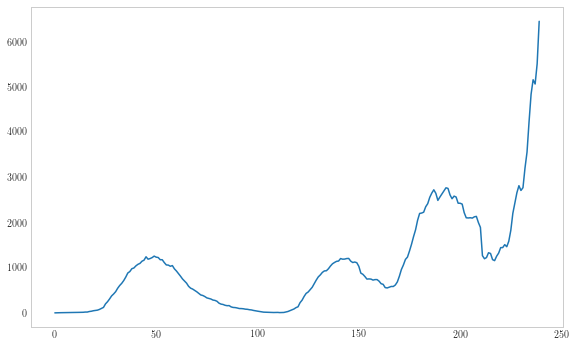

In [79]:
plt.plot(active)

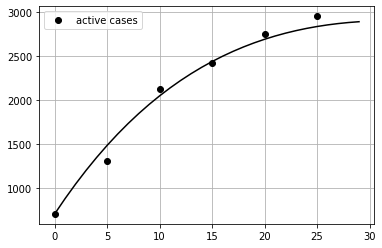

In [135]:
guess = [0.1, 0.1, 0.1]
S0 = 50000
E0 = 10*active_3[0]
I0 = active_3[0]
R0 = removed_3[0]
IC = [S0, E0, I0, R0]

opt = minimize(
    fun=loss, 
    x0=guess,
    args=(active_3, removed_3, IC),
    method='L-BFGS-B',
    bounds=[(1e-5, 1.0)] * len(guess),
    options={'maxiter': 1000, 'disp': True},
)

sol = solve_ivp(
    fun=SEIR, 
    t_span=(0, active_3.size), 
    y0=IC, 
    args=opt.x,
    method='RK45', 
    t_eval=np.arange(0, active_3.size, 1), 
    vectorized=True,
)

plt.plot(active_3, 'ko', markevery=5, label='active cases')
plt.plot(sol.y[2], 'k-')

plt.legend()
plt.grid()
plt.show()